<a href="https://colab.research.google.com/github/QiChen000/Coding3/blob/main/%E2%80%9Cpytorch_vision_deeplabv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### This notebook is optionally accelerated with a GPU runtime.
### If you would like to use this acceleration, please select the menu option "Runtime" -> "Change runtime type", select "Hardware Accelerator" -> "GPU" and click "SAVE"

----------------------------------------------------------------------

# Deeplabv3

*Author: Pytorch Team*

**DeepLabV3 models with ResNet-50, ResNet-101 and MobileNet-V3 backbones**

_ | _
- | -
![alt](https://pytorch.org/assets/images/deeplab1.png) | ![alt](https://pytorch.org/assets/images/deeplab2.png)

In [ ]:
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet101', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_mobilenet_v3_large', pretrained=True)
model.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

All pre-trained models expect input images normalized in the same way,
i.e. mini-batches of 3-channel RGB images of shape `(N, 3, H, W)`, where `N` is the number of images, `H` and `W` are expected to be at least `224` pixels.
The images have to be loaded in to a range of `[0, 1]` and then normalized using `mean = [0.485, 0.456, 0.406]`
and `std = [0.229, 0.224, 0.225]`.

The model returns an `OrderedDict` with two Tensors that are of the same height and width as the input Tensor, but with 21 classes.
`output['out']` contains the semantic masks, and `output['aux']` contains the auxiliary loss values per-pixel. In inference mode, `output['aux']` is not useful.
So, `output['out']` is of shape `(N, 21, H, W)`. More documentation can be found [here](https://pytorch.org/vision/stable/models.html#semantic-segmentation).

In [ ]:
# Download an example image from the pytorch website
import urllib
url, filename = ("https://github.com/pytorch/hub/raw/master/images/deeplab1.png", "deeplab1.png")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

In [ ]:
# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
input_image = Image.open(filename)
input_image = input_image.convert("RGB")
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)['out'][0]
output_predictions = output.argmax(0)

The output here is of shape `(21, H, W)`, and at each location, there are unnormalized probabilities corresponding to the prediction of each class.
To get the maximum prediction of each class, and then use it for a downstream task, you can do `output_predictions = output.argmax(0)`.

Here's a small snippet that plots the predictions, with each color being assigned to each class (see the visualized image on the left).

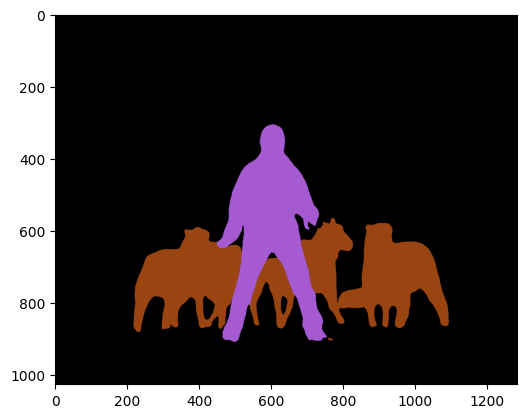

In [ ]:
# create a color pallette, selecting a color for each class
palette = torch.tensor([2 ** 50 - 10, 5 ** 15 - 1, 2 ** 29 - 1])
colors = torch.as_tensor([i for i in range(31)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

# plot the semantic segmentation predictions of 21 classes in each color
r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.size)
r.putpalette(colors)

import matplotlib.pyplot as plt
plt.imshow(r)
# plt.show()

### Model Description

Deeplabv3-ResNet is constructed by a Deeplabv3 model using a ResNet-50 or ResNet-101 backbone.
Deeplabv3-MobileNetV3-Large is constructed by a Deeplabv3 model using the MobileNetV3 large backbone.
The pre-trained model has been trained on a subset of COCO train2017, on the 20 categories that are present in the Pascal VOC dataset.

Their accuracies of the pre-trained models evaluated on COCO val2017 dataset are listed below.

|    Model structure           |   Mean IOU  | Global Pixelwise Accuracy |
| ---------------------------- | ----------- | --------------------------|
| deeplabv3_resnet50           |   66.4      |   92.4                    |
| deeplabv3_resnet101          |   67.4      |   92.4                    |
| deeplabv3_mobilenet_v3_large |   60.3      |   91.2                    |

### Resources

 - [Rethinking Atrous Convolution for Semantic Image Segmentation](https://arxiv.org/abs/1706.05587)